# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral Cloning


---


The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

### Importing Libraries

In [1]:
import os
import matplotlib.image as mpimg
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
%matplotlib inline

### Loading Images

In [2]:
samples = []

data_path = './Data/DriveLogs/'
csv_path_filename = data_path + 'combined_driving_log.csv'
images_path = data_path + 'IMG/'
with open(csv_path_filename) as csvfile:
    reader = csv.reader(csvfile)
    next(reader,'None')
    for line in reader:
        samples.append(line)

print('Total number of frames = ', len(samples))

Total number of frames =  12507


### Data Visualization

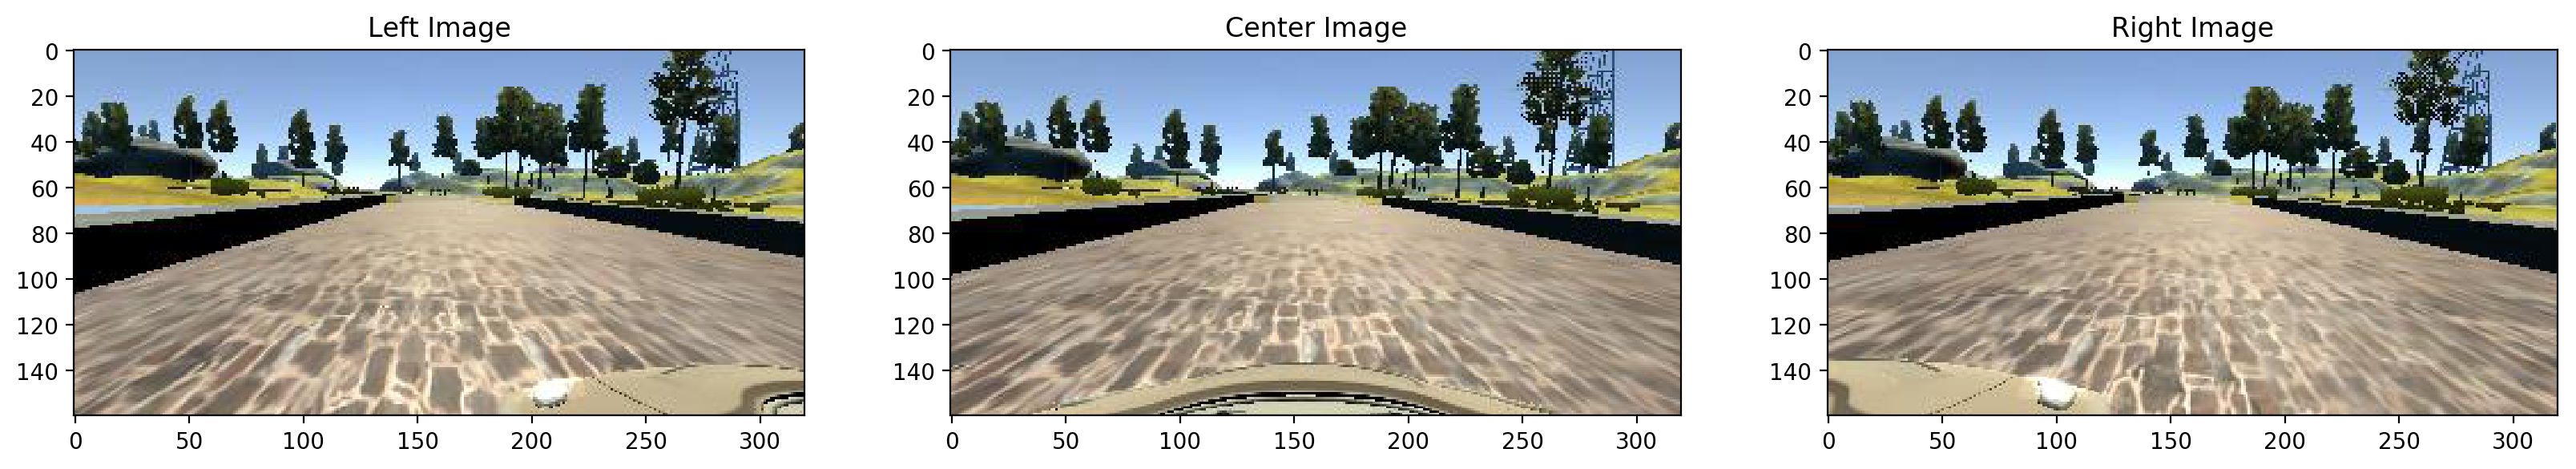

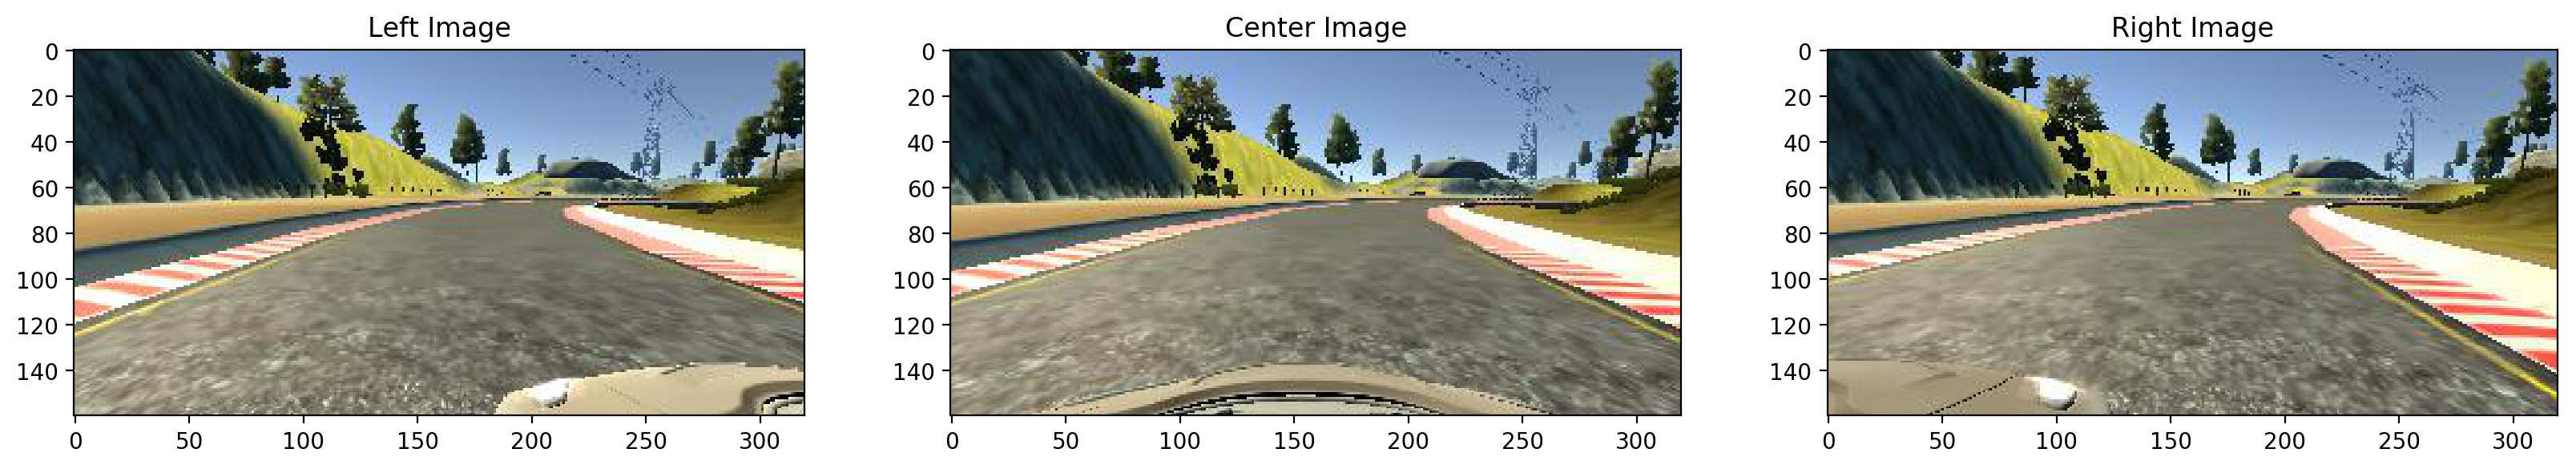

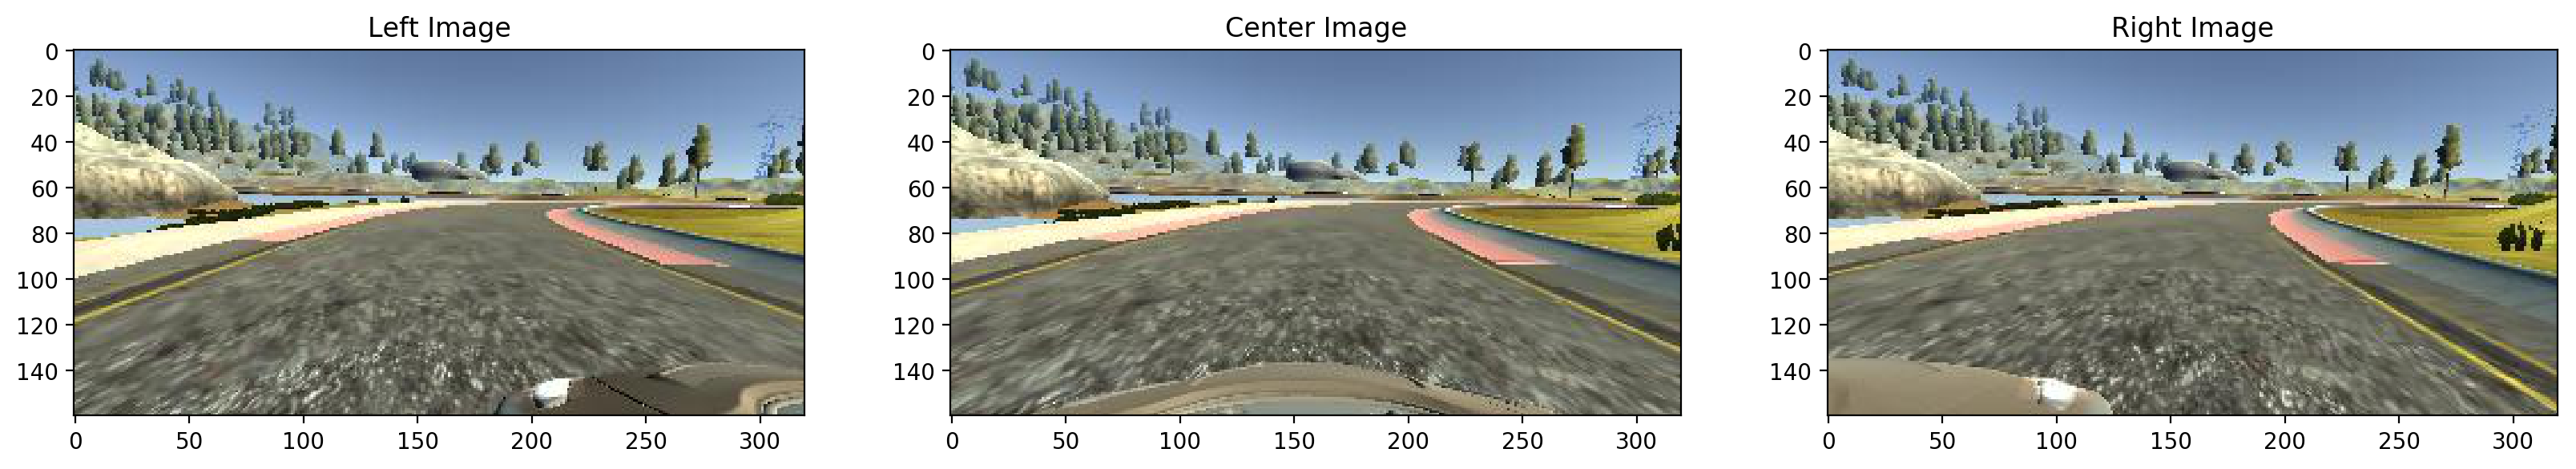

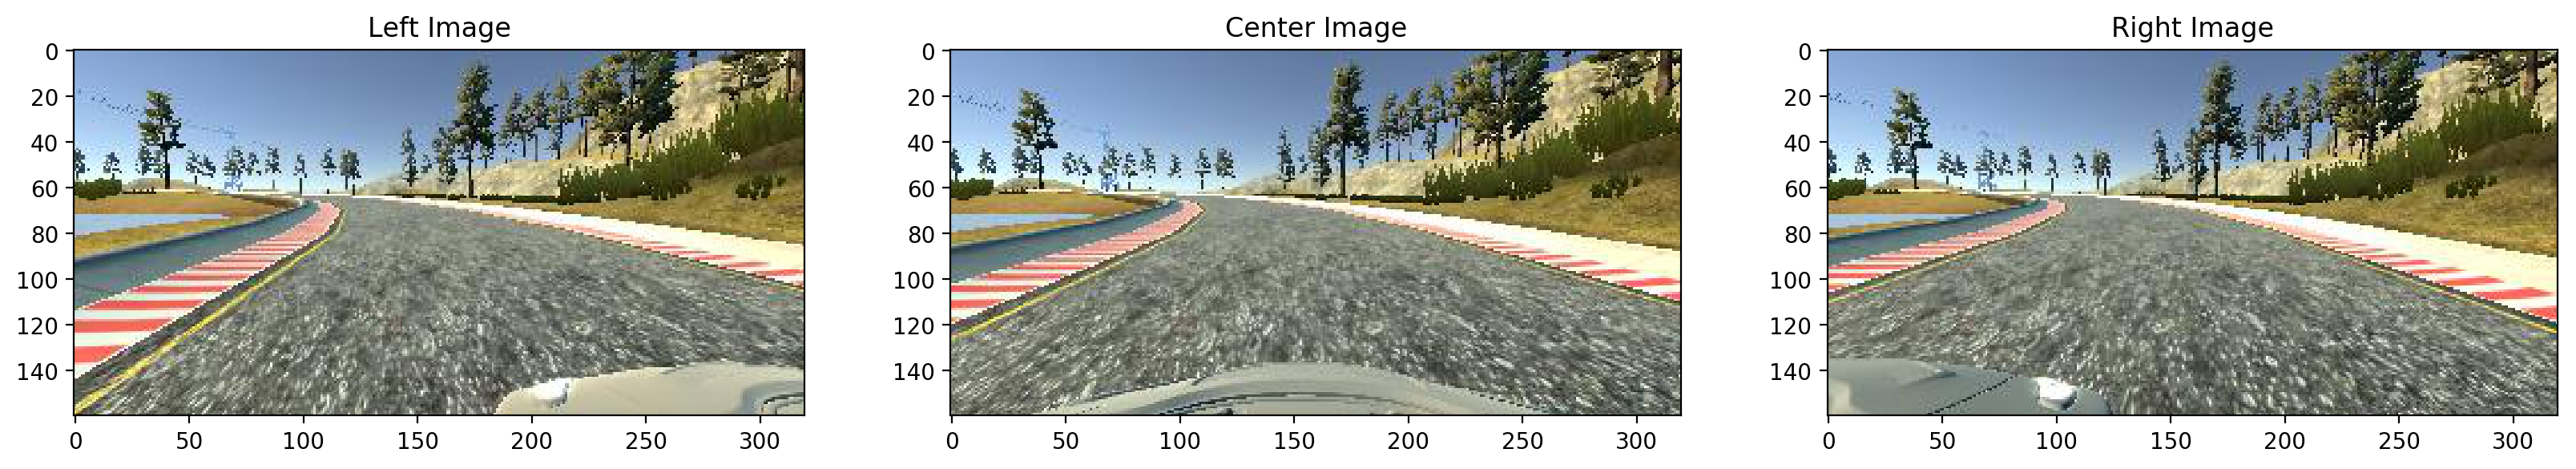

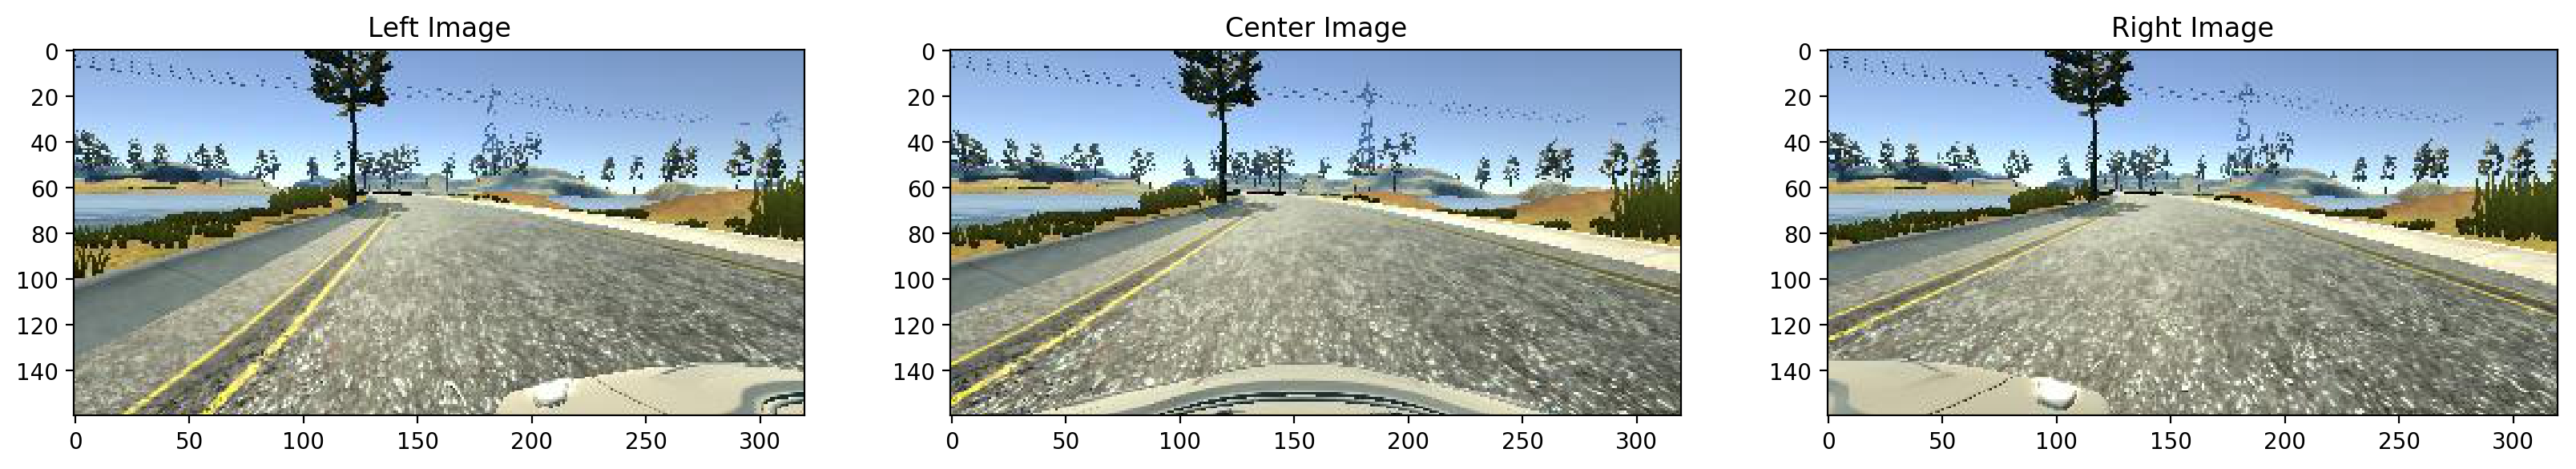

In [3]:
# Printing some statistics and displaying sample images
col_ind = 0
rows_to_display = 5
total_rows = math.floor((len(samples)/(rows_to_display-1)))

sample_images = []
sample_angles = []

for sample in samples[0::total_rows]:
    source_path = sample[0]   #IMG/center_2016_12_01_13_30_48_287.jpg
    filename = source_path.split('/')[-1]  #center_2016_12_01_13_30_48_287.jpg
    plt.figure(figsize=(20, 15), dpi=200)
    col_ind = 0
    for index in ["Left", "Center",  "Right"]:
        col_ind = col_ind + 1
        filename = filename.split('_')  #center_2016_12_01_13_30_48_287.jpg
        filename[0]=index
        filename='_'.join(filename)
        image = cv2.imread(images_path + filename)
        sample_images.append(image)
        plt.subplot(1,3,col_ind)
        plt.title(index + ' Image')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Creating the Network

In [4]:
# Importing libraries
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [5]:
# Creating the model "NVIDIA end-to-end deep learning for self driving cars"
model = Sequential()

model.add(Lambda(lambda x: x / 127.5 - 1, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())

model.add(Dropout(0.5, noise_shape=None, seed=None))

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 33, 64)         36928     
__________

### Creating the Generator

In [6]:
def generator(samples, batch_size=20):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            
            for batch_sample in batch_samples:
                source_path = batch_sample[0]
                filename = source_path.split('/')[-1]  #center_2016_12_01_13_30_48_287.jpg
                for index in ["center", "left", "right"]:
                    filename = filename.split('_')  #center_2016_12_01_13_30_48_287.jpg
                    filename[0]=index
                    filename='_'.join(filename)
                    image = cv2.imread(images_path + filename)
                    images.append(image)
                    if index == "center":
                        images.append(cv2.flip(image, 1))
                        
                correction = 0.3
                angle = float(batch_sample[3])
                angles.append(angle)
                angles.append(-1.0 * angle)
                angles.append(angle + correction)
                angles.append(angle - correction)
                
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [7]:
# Splitting the train and test samples and creating batches using the generator
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

batch_size = 32

print('Number of Training Images:', len(train_samples))
print('Number of Validation Images:', len(validation_samples))

train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

Number of Training Images: 10005
Number of Validation Images: 2502


## Training the Model

In [8]:
epochs = 20

model.compile(loss='mse', optimizer='adam')

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

history_object = model.fit_generator(train_generator, steps_per_epoch =
    (len(train_samples))/batch_size, validation_data = 
    validation_generator,
    validation_steps = len(validation_samples), 
    epochs=epochs, callbacks=callbacks_list, verbose=1)

Epoch 1/20
313/312 [==============================] - 730s - loss: 0.0284 - val_loss: 0.0228
Epoch 2/20
313/312 [==============================] - 716s - loss: 0.0222 - val_loss: 0.0205
Epoch 3/20
313/312 [==============================] - 725s - loss: 0.0197 - val_loss: 0.0185
Epoch 4/20
313/312 [==============================] - 731s - loss: 0.0179 - val_loss: 0.0168
Epoch 5/20
313/312 [==============================] - 724s - loss: 0.0163 - val_loss: 0.0158
Epoch 6/20
313/312 [==============================] - 717s - loss: 0.0151 - val_loss: 0.0157
Epoch 7/20
313/312 [==============================] - 714s - loss: 0.0139 - val_loss: 0.0152
Epoch 8/20
313/312 [==============================] - 724s - loss: 0.0128 - val_loss: 0.0142
Epoch 9/20
313/312 [==============================] - 719s - loss: 0.0118 - val_loss: 0.0140
Epoch 10/20
313/312 [==============================] - 714s - loss: 0.0109 - val_loss: 0.0145
Epoch 11/20
313/312 [==============================] - 713s - loss: 0

### Saving the Model

In [9]:
model.save('model_last_epoch.h5')
model.load_weights("weights.best.hdf5")
model.save('model.h5')

## Visualization

dict_keys(['loss', 'val_loss'])


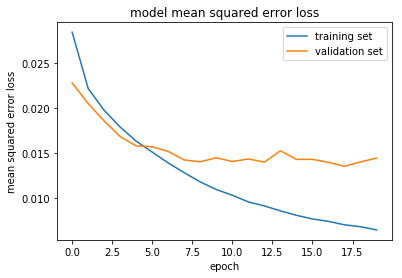

In [16]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Run the Model in the Simulator

In [17]:
# %run drive.py model.h5

### Generate the Video File

In [18]:
# %run drive.py model.h5 run1

In [19]:
# %run python video.py run1 --fps 48

In [20]:
from IPython.display import HTML

In [21]:
%%HTML
<video width="480" height="240" controls>
  <source src="run1.mp4" type="video/mp4">
</video>